In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import shift
import ipywidgets as widgets
from IPython.display import display, clear_output
from velan import *

# Synthetic data generation

Input the t0 and velocity value for each layer inside the list, determine number of channel (trace), and offset length.

In [2]:
channel = 100 # number of trace

# time NMO
t_value = [0.2, 0.4, 0.5, 0.7, 0.8] # t0 value in s
dt = 0.002 # sampling rate in ms

# velocity model
vel_value = [2600, 2700, 2800, 3400, 4000] # velocity value in m/s

# offset
x = np.linspace(0,2250,channel)

Create synthetic seismogram using NMO formula to calculate the traveltime. Then, turned into amplitude matrix to convoluted with ricker wavelet.

NMO Formula
$$
t_{NMO} = \sqrt{t_{0}^2 + \frac{x^2}{v_{NMO}^2}}
$$
Ricker Wavelet Formula
$$
A = \frac{1 - 2\pi^2 f^2 t^2}{e^{\pi^2 f^2 t^2}}
$$

The output will be seismic trace matrix and time list

In [3]:
amplitude, Y = create_synthetic(t_value, vel_value, channel, x, dt=dt, wavelet_freq=25)

Using plot_seismogram function to show. plot_option could be changed with:

- plot_option = 0 or plot_option = 'wiggle' : Show the seismogram in wiggle trace view.
    
- plot_option = 1 or plot_option = 'color' : Show the seismogram in filled color trace view.
    
- plot_option = 2 or plot_option = 'both' : Show the seismogram in wiggle trace and filled color, 2 plots.
    
- plot_option = 3 or plot_option = 'stacked' : Show single stacked trace from input data.

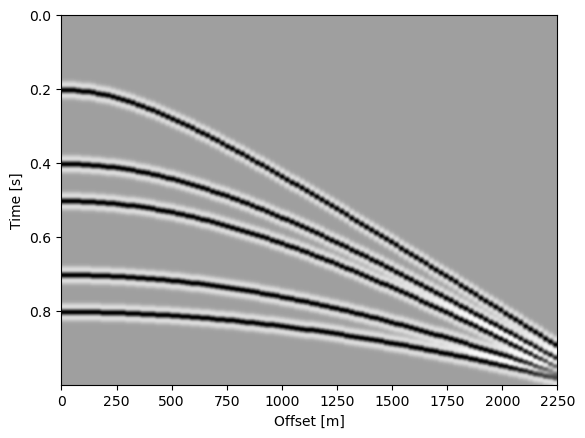

In [4]:
fig, ax = plt.subplots() # if plot_option = 2, don't use this line
plot_seismogram(ax, amplitude, x, Y, plot_option=1, cmap='Greys')

Random noise added to the data

In [5]:
amplitude1 = amplitude.copy() + 0.03 * np.random.randn(*amplitude.shape)

In [2]:
### Real data example

amplitude1 = np.load('data_example.npy')
dt = 0.002
trace_distance = 25
x = np.arange(0, trace_distance*amplitude1.shape[1], trace_distance)
Y = np.arange(0, amplitude1.shape[0]*dt, dt)

# Trace shifting view

Put the correct velocity over the time to match with the curve. We will try to show how NMO could *flattening the curve* from top to bottom by shifting the trace. However, this result is just to visualize and will not used for further process.

You can change the *min, max* and *step* value in the t0 and v below to match with your data.

In [6]:
widgets.interact(NMO_correction, data=widgets.fixed(amplitude1*10), offset=widgets.fixed(x), time=widgets.fixed(Y),
                 t0=widgets.FloatSlider(min=np.min(Y),max=np.max(Y),step=0.1,value=0.2,description='Time'),
                 v=widgets.FloatSlider(min=1000,max=5000,step=100,value=2000,description='NMO Velocity'));

interactive(children=(FloatSlider(value=2000.0, description='NMO Velocity', max=5000.0, min=1000.0, step=100.0…

# Semblance creating and analysis

Semblance is one of the most widely used guidance for seismic velocity analysis. By performing NMO and stacking over the time with certain velocity range, semblance could show the highest coherency related to perfect NMO result, means the correct velocity at certain time.

Semblance formula based on Geldart & Sheriff (2004):

$$
Semblance = \frac{\sum\limits_{t = t_0}^{t_0+\Delta t}\biggl(\sum\limits_{i = 1}^{N} trace_{t,i}\biggl)^2 }{N \sum\limits_{t = t_0}^{t_0+\Delta t}\sum\limits_{i = 1}^{N} (trace_{t,i})^2}
$$

Unfortunately, semblance result is not so good in the real data tested and running so slow.

In [7]:
T0_range = Y
vel_range = np.arange(2000, 5000, 100) # start, stop, and step of velocity range to create the semblance
semblance_result = semblance(amplitude1, T0_range, vel_range, x)

Slide the time and velocity to hit the high energy (shown in red) in semblance panel. Click *Save Value* to get the result and *Clear Value* to delete all picked result. The output will be time and velocity list that can be used for further process.

In [8]:
time0 = widgets.FloatSlider(min=np.min(Y),max=np.max(Y),step=0.1,value=0.2,description='Time')
velo = widgets.FloatSlider(min=1000,max=5000,step=100,value=2000,description='NMO Velocity')

save_button = widgets.Button(description='Save Value')
clear_button = widgets.Button(description='Clear Value')
output = widgets.Output()
saved_value = None

T0 = []
V = []
def save_slider_value(b):
    global saved_value
    saved_value_1 = time0.value
    saved_value_2 = velo.value
    T0.append(saved_value_1)
    V.append(saved_value_2)
    with output:
        print(f'Time and Velocity: {saved_value_1, saved_value_2}')

def clear_saved_value(b):
    global saved_value_1
    saved_value_1 = None
    T0.clear()
    V.clear()
    with output:
        clear_output()
        
save_button.on_click(save_slider_value)
clear_button.on_click(clear_saved_value)

display(save_button, clear_button, output)
widgets.interact(semblance_analysis, data=widgets.fixed(amplitude1), offset=widgets.fixed(x),
                 time=widgets.fixed(Y), Semblance=widgets.fixed(semblance_result), vel_range=widgets.fixed(vel_range),
                 t0=time0, v=velo, Veloo=widgets.fixed(V), Timee=widgets.fixed(T0));

Button(description='Save Value', style=ButtonStyle())

Button(description='Clear Value', style=ButtonStyle())

Output()

interactive(children=(FloatSlider(value=0.2, description='Time', max=0.998), FloatSlider(value=2000.0, descrip…

In [13]:
V

[2600.0, 2700.0, 2800.0, 3400.0, 4000.0]

# Applied NMO correction

To apply the NMO correction that stretch all of the trace based on the velocity picked, it is recommended to use code from [SEG Wiki on Step-by-step NMO Correction](https://wiki.seg.org/wiki/Step-by-step_NMO_correction) with a little bit adjustment. But as the input data, I will give you the code to interpolate (and extrapolate) the output from previous process.

In [14]:
interpolation = interp1d(T0, V, kind='linear', fill_value='extrapolate')
V_NMO = interpolation(Y)

With V_NMO as the input for *velocities* parameter, the result should be somewhat like this:

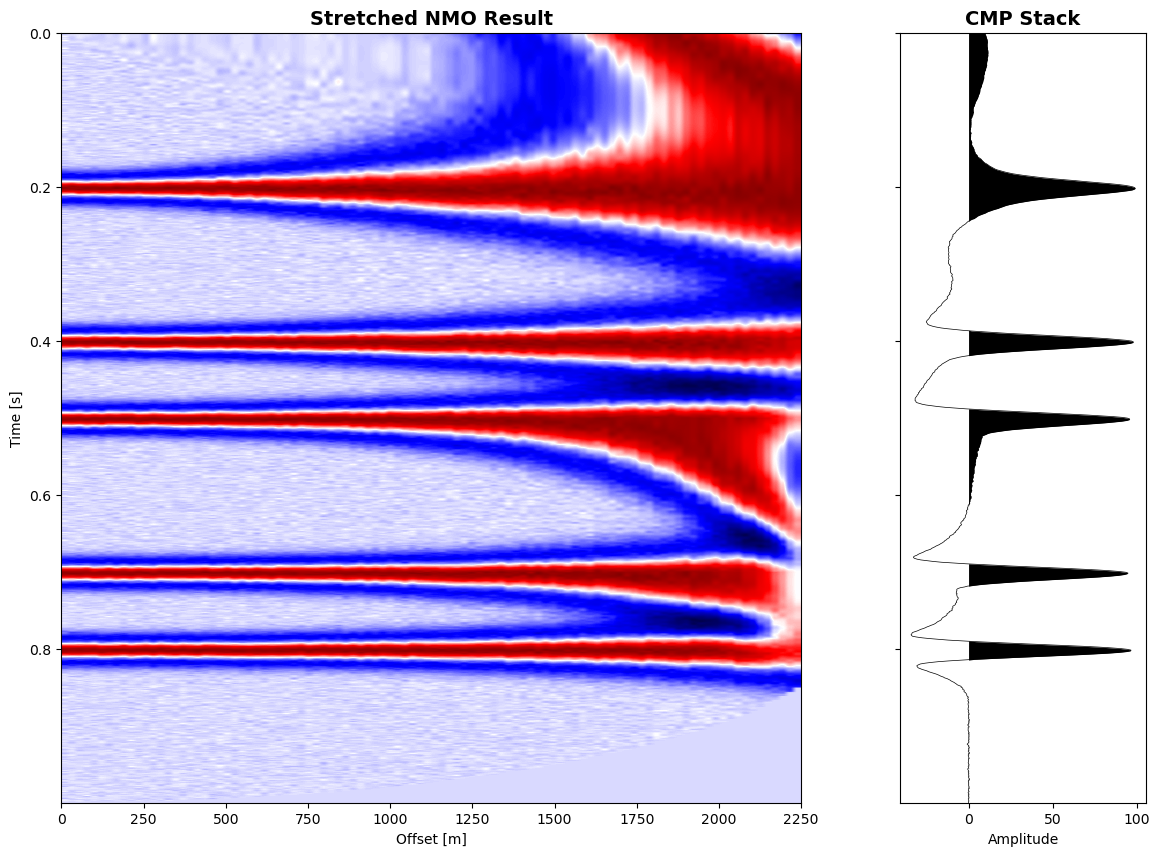